In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from misc import torchutils, imutils, pyutils
from PIL import Image
import matplotlib.pyplot as plt

In [28]:
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128,
           255, 255, 255]

object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']


def colorize_mask(mask):
    if isinstance(mask, np.ndarray):
        mask = Image.fromarray(mask.astype(np.uint8))
    new_mask = mask.convert('P')
    new_mask.putpalette(palette)
    return new_mask.convert('RGB')


img_num = '2007_002293'


org_img = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012/JPEGImages/{}.jpg'.format(img_num)
# scp yipingwang@kingwood.cs.uvic.ca:/data/home/yipingwang/data/CAMv2/2007_002105.npy .
cam_dict_path = '/Users/Andy/Projects/{}.npy'.format(img_num)

img = Image.open(org_img).convert('RGB')
cams_dict = np.load(cam_dict_path, allow_pickle=True).item()
high_res = cams_dict['high_res'].squeeze()
keys = cams_dict['keys'].squeeze()

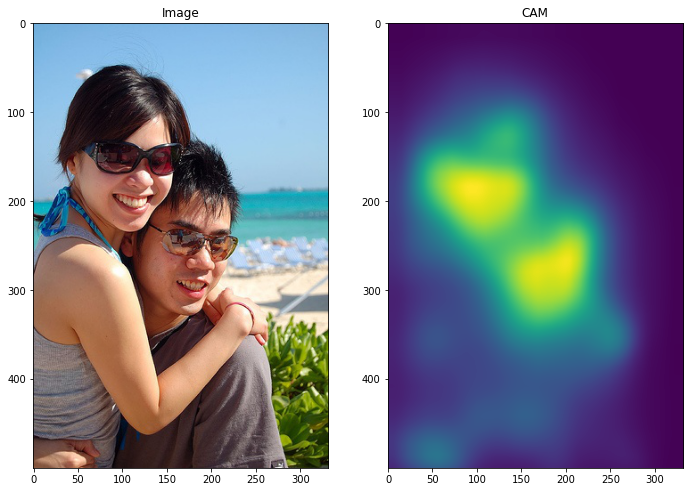

In [29]:
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(231)
plt.title('Image')
ax1.imshow(img)
ax2 = fig.add_subplot(232)
plt.title('CAM')
ax2.imshow(high_res)

In [30]:
import copy

img = np.asarray(Image.open(org_img).convert('RGB'))
cams = cams_dict['high_res']
keys = np.pad(cams_dict['keys'] + 1, (1, 0), mode='constant')


conf_fg_thres = np.percentile(cams,70)
conf_bg_thres = 0.05

# 1. find confident fg & bg
fg_conf_cam = np.pad(cams, ((1, 0), (0, 0), (0, 0)),
                     mode='constant', constant_values=conf_fg_thres)
fg_conf_cam = np.argmax(fg_conf_cam, axis=0)

pred = imutils.crf_inference_label(
    img, fg_conf_cam, n_labels=keys.shape[0])
fg_conf = keys[pred]

bg_conf_cam = np.pad(cams, ((1, 0), (0, 0), (0, 0)),
                     mode='constant', constant_values=conf_bg_thres)
bg_conf_cam = np.argmax(bg_conf_cam, axis=0)
pred = imutils.crf_inference_label(
    img, bg_conf_cam, n_labels=keys.shape[0])
bg_conf = keys[pred]

# 2. combine confident fg & bg
conf = fg_conf.copy()
conf[fg_conf == 0] = 255
conf[bg_conf + fg_conf == 0] = 0

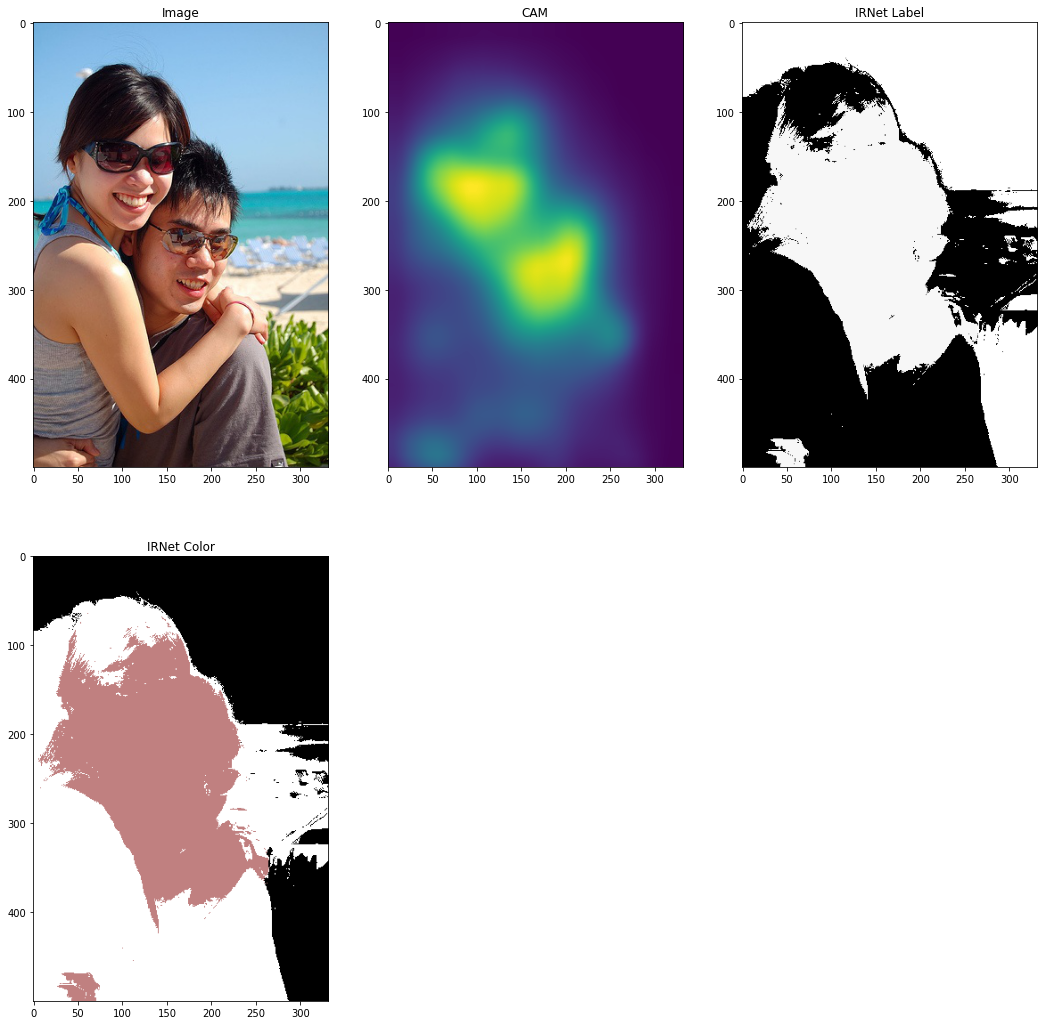

In [31]:
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(231)
plt.title('Image')
ax1.imshow(img)
ax2 = fig.add_subplot(232)
plt.title('CAM')
ax2.imshow(cams_dict['high_res'].squeeze())
ax3 = fig.add_subplot(233)
plt.title('IRNet Label')
ax3.imshow(conf, cmap='Greys')
ax4 = fig.add_subplot(234)
plt.title('IRNet Color')
ax4.imshow(colorize_mask(conf))